# Oracle: Reflex Control With Look-Ahead

Steers the car using a PD controller on the estimated $y_m$ track median offset and track curve look-ahead.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
import numpy as np
from belief import BeliefDriveItEnv
from car import CarSpecifications, Car
from utils import Color
from DriveItCircuit import *

num_episodes = 1
time_limit = 10.
gamma = 0.99
noisy = True
random_position = True
speed_limit = 1.8

car = Car.HighPerf(Color.green, speed_limit)
bots = []
#bots = [Car.HighPerf(Color.green, speed_limit), \
#        Car.Simple(Color.orange, 1.0), \
#        Car.Simple(Color.purple, 1.2)]

env = BeliefDriveItEnv(car, bots, time_limit, noisy)
b = env._reset(random_position)
b_ = b
done = False
reward_episode = 0.0
reward_sum = 0.0
crashes = 0
obs, bel, pos, actions = [env.tracker.observation], [b], [env.tracker.position], []
fs = []

ky, kdy = -3.0, -3.0
kth, kdth = 0.0, 0.0
kkt, kka, kdka = 0.0, 3.0, 0.1
epsilon = 0.05

for i_episode in range(1, num_episodes + 1):
    
    while not done:
        if num_episodes < 2 and time_limit < 60.0:
            env.render()

        y, th, v, k, kt, ka = b
        y_, th_, v_, k_, kt_, ka_ = b_
        dy, dth, dka = y - y_, th - th_, ka - ka_
        b_ = b
        
        fy = ky * y + kdy * dy
        fth = kth * dth + kdth * dth
        fk = kkt * (kt - k) + kka * (ka - k) + kdka * (dka - k)
        f = fy + fth + fk
        if f > epsilon: action = 1
        elif f < epsilon: action = 2
        else: action = 0
        
        
        safe_throttle = car.specs.safe_turn_speed( \
            max(abs(k), abs(ka)), 0.9) / car.specs.v_max
        if v < safe_throttle - epsilon:
            action += 3
        elif v > safe_throttle + epsilon:
            action += 6

        b, r, done, info = env.step(action)
        bel.append(b)
        obs.append(env.tracker.observation)
        pos.append(env.tracker.position)
        actions.append(action)
        fs.append(f)
        reward_episode += r

    if num_episodes <= 10:
        print('Episode %d %s. reward: %f, laps: %f' % \
              (i_episode, info['done'], reward_episode, \
               reward_episode / lap_median_length))

    if info['done'] != 'complete':
        crashes += 1

    reward_sum += reward_episode
    reward_episode = 0
    o = env._reset(random_position)
    o_ = o
    done = False

if num_episodes > 1:
    print('Average reward: %f with %d crashes' % \
          (reward_sum / num_episodes, crashes))

Episode 1 complete. reward: 15.753605, laps: 3.129259


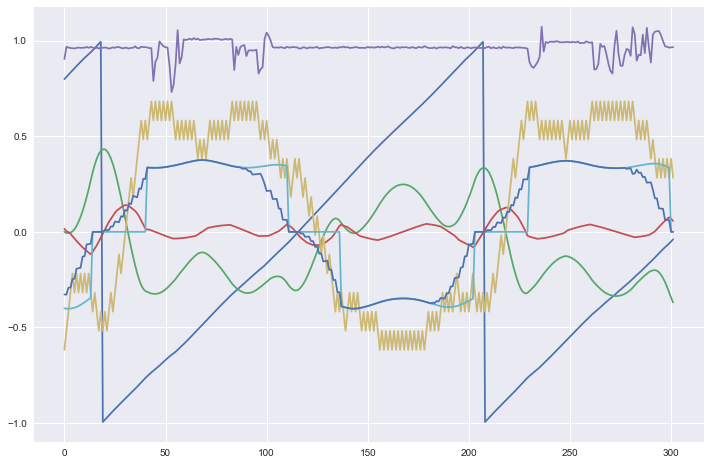

In [72]:
_ = plt.plot([b for b in bel])

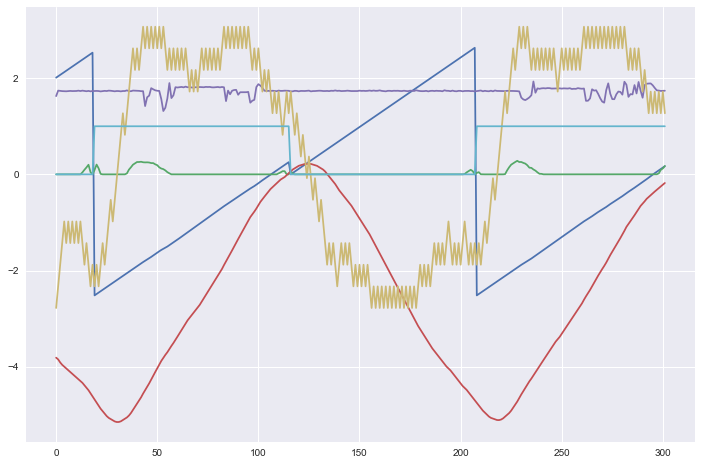

In [73]:
_ = plt.plot([o for o in obs])

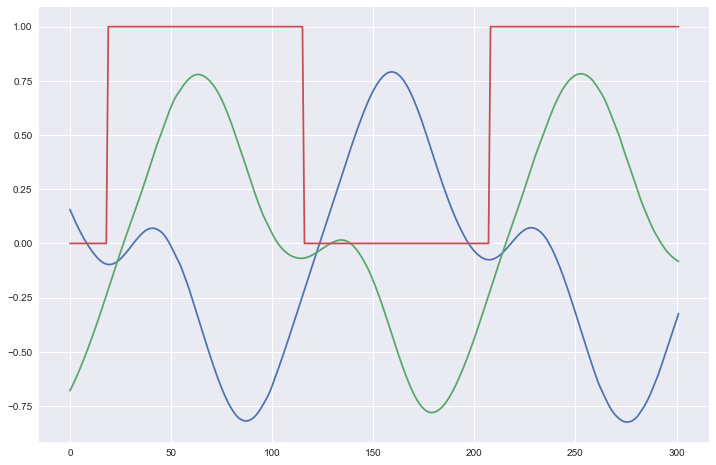

In [74]:
_ = plt.plot([p for p in pos])

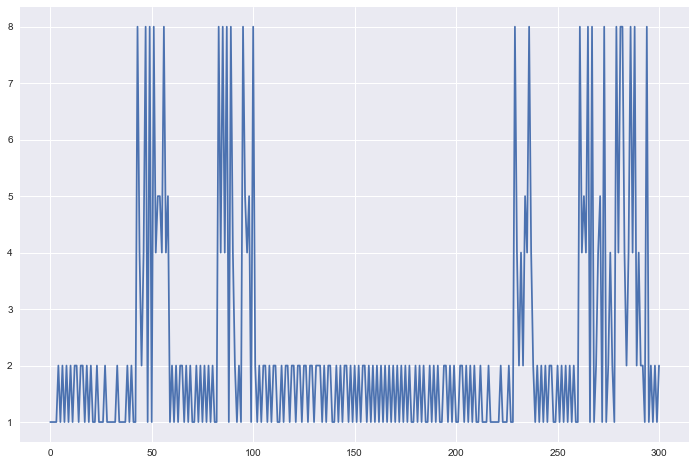

In [75]:
_ = plt.plot([a for a in actions])

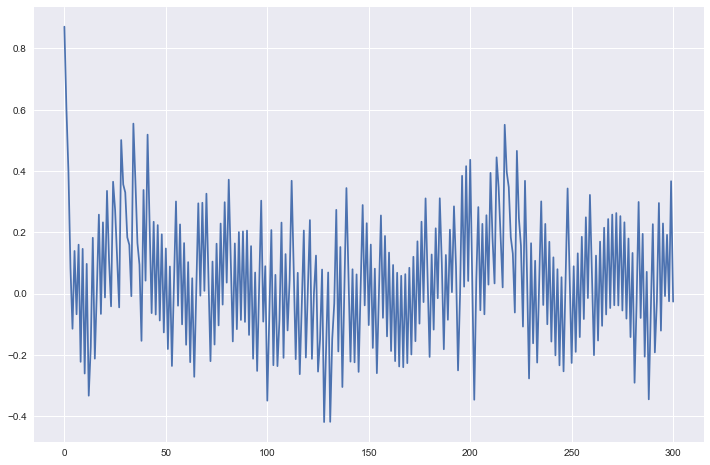

In [76]:
_ = plt.plot([f for f in fs])

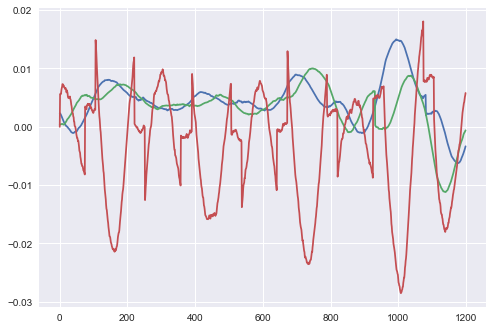

In [4]:
_ = plt.plot([e for e in err])

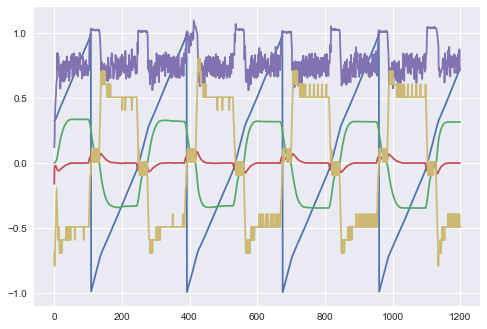

In [46]:
_ = plt.plot([pos[0].normalize(b) for b in bel])

In [47]:
coord = [median_to_cartesian(s[0],s[1],s[2]) for s in bel]
x = [c[0] for c in coord]
y = [c[1] for c in coord]

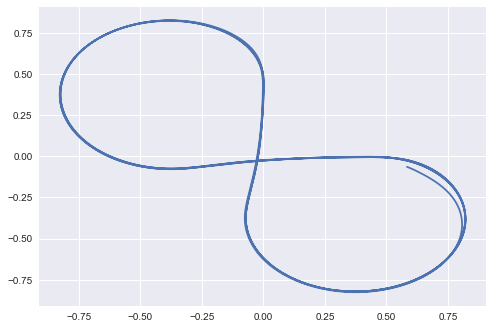

In [48]:
_ = plt.plot(x, y)

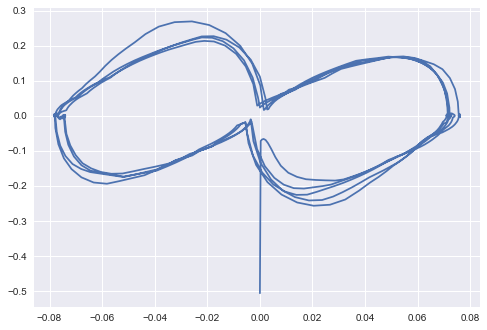

In [49]:
med = [(s[0],s[1],s[2]) for s in bel]
xm = [c[0] for c in med]
ym = [c[1] for c in med]
thm = [c[2] for c in med]
_ = plt.plot(ym, thm)

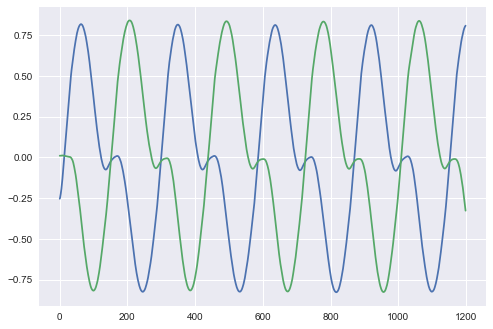

In [39]:
_ = plt.plot([p[:-1] for p in carpos])

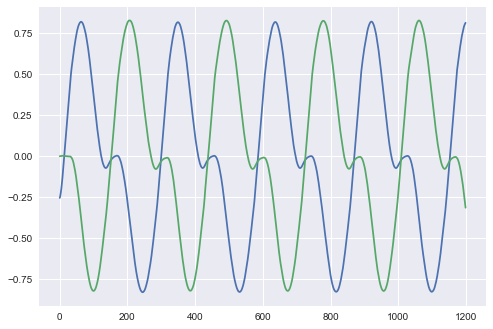

In [40]:
_ = plt.plot([p[:-1] for p in belpos])

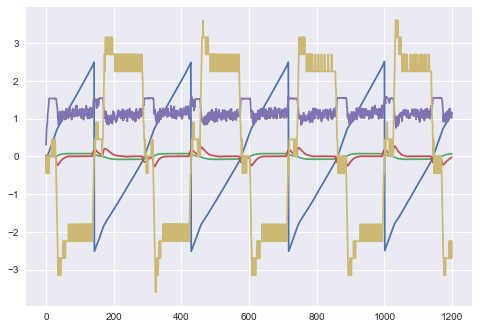

In [41]:
_ = plt.plot([b for b in bel])

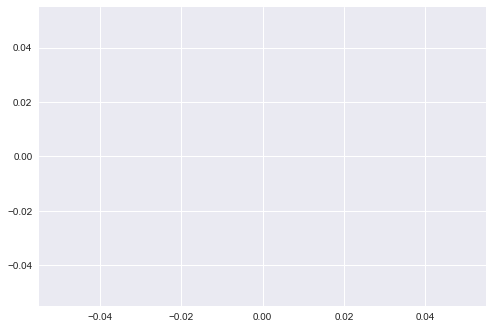

In [42]:
_ = plt.plot([o for o in obs])

In [11]:
env._reset(random_position)

[array([-0.30159535,  0.        , -0.88246308,  0.        ,  2.21666667])]

In [12]:
env.render()

In [45]:
# out penalty = max discounted reward for median laps at full speed
2.5 * dt / (1 - gamma)

8.333333333333325

In [13]:
c = cars[0]
isinstance(c.front_left, Part)

True